# iSNVs on tree

In this notebook, we map iSNVs to the tree, identify transmission clusters from the tree and compare shared variants by transmission clusters, and compare shared variants by LBI.


In [18]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import baltic as bt

In [2]:
# iSNVs
def load_df(file):
    '''
    Loads metadata tsv as df.
    '''
    with open(file) as tfile:
        df = pd.read_csv(tfile, sep = '\t')
        if 'nwgc_id' in df.columns:
            df['nwgc_id'] = df.nwgc_id.astype('str')
        if 'position' and 'variant' in df.columns:
            df['snv'] = df['position'].astype('str').str.cat(df['variant'],sep="")
    return df

scan_snvs = load_df('../results/snvs_scan_all.tsv')
scan_snvs = scan_snvs[scan_snvs.avg_ct < 22]

In [32]:
# LoadsJSON tree
def load_tree(file):
    with open(file) as jfile:
        tree_json = json.load(jfile)
    json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
    tree=bt.loadJSON(tree_json,json_translation)
    return tree

tree, meta = load_tree('../../spheres-augur-build/auspice/ncov_washington_all.json')



Tree height: 0.735170
Tree length: 647.110598
multitype tree
annotations present

Numbers of objects in tree: 22913 (10793 nodes and 12120 leaves)



## Map iSNVs to tree

In [8]:
def add_ref_base(df):
    df['snv'] = df['genome'] + df['position'].astype('str') + df['variant']
    return df

scan_snvs = add_ref_base(scan_snvs)

In [42]:
def enumerate_tree_muts(tree):
    '''
    Modifed from Louise Moncla's within-host code: https://github.com/lmoncla/ncov-WI-within-host/blob/master/scripts/query-within-host-snvs-in-tree.ipynb
    '''
    tree_snps = {}
    for k in tree.Objects:
        if 'branch_attrs' in k.traits:
            if 'mutations' in k.traits['branch_attrs']:
                if 'nuc' in k.traits['branch_attrs']['mutations']:
                    nt_muts = k.traits['branch_attrs']['mutations']['nuc']
                    for n in nt_muts:
                        if n not in tree_snps: 
                            tree_snps[n] = {"branches_with_snv":[], "arose_on_tip":0, "arose_on_internal_node":0}
                        
                        tree_snps[n]["branches_with_snv"].append(k.name)

                        if k.branchType == "node":
                            leaves = 0 #len(k.leaves)
                            nodes = 1
                        elif k.branchType == "leaf":
                            leaves = 1
                            nodes = 0

                        tree_snps[n]["arose_on_tip"] += leaves
                        tree_snps[n]["arose_on_internal_node"] += nodes
                        
    return(tree_snps)
tree_snps = enumerate_tree_muts(tree)

In [43]:
def dict_to_df(snps):
    df = pd.DataFrame.from_dict(snps, orient = 'index')
    df.reset_index(inplace=True)
    df.columns = ['snv','branches_with_snv','arose_on_tip','arose_on_internal_node']
    return df

df_tree_snps = dict_to_df(tree_snps)

In [79]:
def map_snvs(tree_df, snvs):
    counts = pd.value_counts(snvs.snv).to_frame(name='samples_in').rename_axis('snv').reset_index()
    freq = snvs.groupby('snv').mean().reset_index()
    freq.rename(columns={'frequency':'avg_frequency'}, inplace=True)
    df_snvs = counts.merge(freq.loc[:, ['avg_frequency', 'snv']])
    df_snvs = df_snvs.merge(tree_df, how = 'left')
    df_snvs[['arose_on_internal_node', 'arose_on_tip']] = df_snvs[['arose_on_internal_node', 'arose_on_tip']].fillna(value=0)
    df_snvs['times_arose'] = df_snvs['arose_on_tip'] + df_snvs['arose_on_internal_node']
    return df_snvs

df_snvs = map_snvs(df_tree_snps, scan_snvs)

In [80]:
df_snvs

,snv,samples_in,avg_frequency,branches_with_snv,arose_on_tip,arose_on_internal_node,times_arose
0,C9502T,74,0.046762,[USA/WA-S421/2020],1.0,0.0,1.0
1,G1730A,71,0.034350,[USA/WA-S846/2020],1.0,0.0,1.0
2,G19406A,36,0.014032,NaN,0.0,0.0,0.0
3,C13225T,33,0.014453,"[USA/WA-S291/2020, USA/WA-UW212/2020, USA/WA-U...",3.0,0.0,3.0
4,C25777T,32,0.014672,[Algeria/G0638_2264/2020],1.0,0.0,1.0
...,...,...,...,...,...,...,...
613,G22487C,1,0.020566,"[USA/WA-S1018/2020, NODE_0003865, NODE_0005276...",2.0,2.0,4.0
614,C17397A,1,0.017094,NaN,0.0,0.0,0.0
615,C16887T,1,0.039421,"[Singapore/685/2020, USA/MN-MDH-1361/2020, USA...",17.0,5.0,22.0
616,G2441A,1,0.013986,"[USA/WA-S60/2020, USA/FL-BPHL-1283/2020]",2.0,0.0,2.0


In [66]:
len(df_snvs)

618

In [65]:
len(df_snvs[(df_snvs.arose_on_internal_node == 0) & (df_snvs.arose_on_tip == 0)])

461

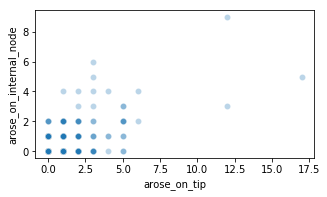

In [141]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
#ax1 = sns.kdeplot(data = df_snvs[~((df_snvs.arose_on_internal_node == 0) & (df_snvs.arose_on_tip == 0))], 
                  #x = 'arose_on_tip', y='arose_on_internal_node', cmap="Reds", shade=True, bw_method=.15, levels=20, thresh=0)
 

ax1 = sns.scatterplot(data = df_snvs, x = 'arose_on_tip', y='arose_on_internal_node', alpha=0.3, ax=ax1)
ax1.set_aspect('equal')

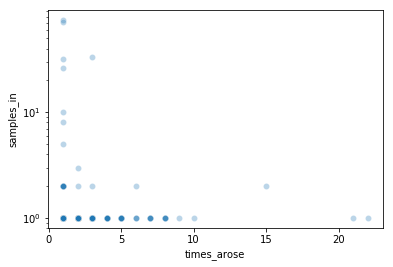

In [131]:
ax = sns.scatterplot(data=df_snvs[df_snvs.times_arose >0], x = 'times_arose', y = 'samples_in', alpha = 0.3)
ax.set_yscale('log')

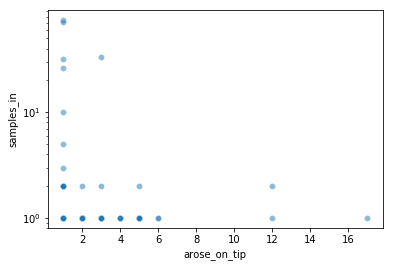

In [126]:
ax = sns.scatterplot(data=df_snvs[df_snvs.arose_on_tip >0], x = 'arose_on_tip', y = 'samples_in', alpha=0.5)
ax.set_yscale('log')

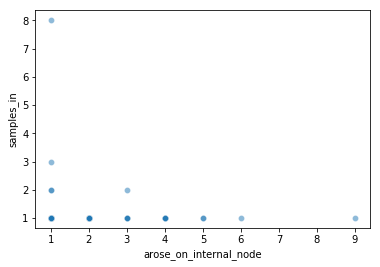

In [128]:
ax = sns.scatterplot(data=df_snvs[df_snvs.arose_on_internal_node >0], x = 'arose_on_internal_node', y = 'samples_in', alpha=0.5)
#ax.set_yscale('log')

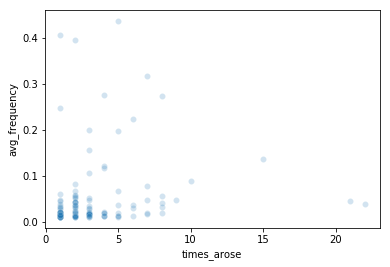

In [132]:
ax = sns.scatterplot(data=df_snvs[df_snvs.times_arose >0], x = 'times_arose', y = 'avg_frequency', alpha = 0.2)
#ax.set_yscale('log')

In [ ]:
d

## Identify clusters

In [89]:
def extract_washington_subtrees(baltic_tree):
    """
    Code taken from Seattle Flu Augur Build. Function takes in a baltic tree object and returns a list of baltic tree objects.
    Each returned tree object represents a point in the tree in which the tree moved from
    a non-seattle deme into seattle. Note that this will return sub-sub trees, e.g.
    where the clade moves into Washington, leaves Washington, and then strains within that clade
    return to seattle (this scenario would make 2 separate subtrees, even though they are nested).
    If that behavior is not desired, the returned list must be pruned out of any trees that have an
    intersection of internal nodes.
    """
    subtrees_list = []
    for k in sorted(baltic_tree.Objects, key = lambda x:x.height):
        parent = k.parent
        k_division = k.traits['division']
        parent_division = k.parent.traits['division']
        if k_division != parent_division and k_division == 'Washington':
            washington_subtree = baltic_tree.subtree(k)
            subtrees_list.append(washington_subtree)
    return subtrees_list

In [98]:
def extract_washington_subtrees(baltic_tree):
    """
    Code taken from Seattle Flu Augur Build. Function takes in a baltic tree object and returns a list of baltic tree objects.
    Each returned tree object represents a point in the tree in which the tree moved from
    a non-seattle deme into seattle. Note that this will return sub-sub trees, e.g.
    where the clade moves into Washington, leaves Washington, and then strains within that clade
    return to seattle (this scenario would make 2 separate subtrees, even though they are nested).
    If that behavior is not desired, the returned list must be pruned out of any trees that have an
    intersection of internal nodes.
    """
    subtrees_list = []
    for k in sorted(baltic_tree.Objects, key = lambda x:x.height):
        parent = k.parent
        if 'division' in k.traits:
            print(k.traits)
            k_division = k.traits['division']
            parent_division = k.parent.traits['division']
            if k_division != parent_division and k_division == 'Washington':
                washington_subtree = baltic_tree.subtree(k)
                subtrees_list.append(washington_subtree)
    return subtrees_list

In [99]:
trees = extract_washington_subtrees(tree)
wa_subtrees = get_basal_subtree(trees)

{'branch_attrs': {'labels': {'aa': 'ORF1a: N2708S, F2908I'}, 'mutations': {'ORF1a': ['N2708S', 'F2908I'], 'nuc': ['A3778G', 'A8388G', 'T8987A']}}, 'name': 'Wuhan/IPBCAMS-WH-01/2019', 'node_attrs': {'age': {'value': '65'}, 'author': {'author': 'Lili Ren et al', 'value': 'Lili Ren et al A'}, 'clade_membership': {'value': '19A'}, 'country': {'confidence': {'China': 1.0}, 'entropy': -1.000088900581841e-12, 'value': 'China'}, 'div': 2.9420536960932986, 'division': {'value': 'Hubei'}, 'division_exposure': {'value': 'Hubei'}, 'genbank_accession': {'value': 'MT019529'}, 'gisaid_epi_isl': {'value': 'EPI_ISL_402123'}, 'host': {'value': 'Human'}, 'legacy_clade_membership': {'value': 'unassigned'}, 'location': {'value': 'Wuhan'}, 'num_date': {'confidence': [2019.9794520547946, 2019.9794520547946], 'value': 2019.9794520547946}, 'originating_lab': {'value': 'Institute of Pathogen Biology, Chinese Academy of Medical Sciences & Peking Union Medical College'}, 'recency': {'value': 'Older'}, 'region': {

KeyError: 'division'